# Power density spectrum

**real datasets**:

- reyes 18ch - 20.0kHz - 4385.500s
- Horvath 128ch - 20.0kHz - 3688.668s

**simulations**:
- npx-32ch-hex_O_simulated 
- npx-384ch-hex_O1_simulated


TODO:

- What is the unit of amplitude of the Reyes recording trace (mV or microVolt)?
- our is in mV (BlueConfig under lfp report)
- plot by channel and by layer 



### Setup

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

#### Setup `Reyes` (real dataset)

- model: rat
- duration: 4385.500s
- 18 channels
- sampling frequency: 20,000 Hz



In [8]:
DATA_PATH_reyes = "/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/reyes/Exp09/S001E009F002_Raw.raw"
CHANNEL_ID_reyes = 10 # contact id

#### Setup `Horvath` (real dataset)

In [2]:
DATA_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/horvath/Rat01/Insertion1/Depth2/Rat01_Insertion1_Depth2.nwb"
CHANNEL_ID_horvath = 10

#### Setup `NPX-32CH-simulated_hex_O`

In [17]:
EXPERIMENT_32 = "silico_neuropixels"
SIMULATION_DATE_32 = "2023_02_19"
data_conf_32, param_conf_32 = get_config(EXPERIMENT_32, SIMULATION_DATE_32).values() # confs
RAW_RECORDING_PATH_32 = data_conf_32["recording"]["output"] # our model
CHANNEL_ID_32 = 0 # set channel

2023-08-23 14:45:30,372 - root - utils.py - get_config - INFO - Reading experiment config.
2023-08-23 14:45:30,402 - root - utils.py - get_config - INFO - Reading experiment config. - done


#### Setup `NPX-384CH-simulated_hex_O1`

In [26]:
EXPERIMENT_384 = "silico_neuropixels"
SIMULATION_DATE_384 = "2023_08_17"
data_conf_384, param_conf_384 = get_config(EXPERIMENT_384, SIMULATION_DATE_384).values()
RAW_RECORDING_PATH_384 = data_conf_384["recording"]["output"] # our model
CHANNEL_ID_384 = 30

2023-08-23 14:57:49,996 - root - utils.py - get_config - INFO - Reading experiment config.
2023-08-23 14:57:50,014 - root - utils.py - get_config - INFO - Reading experiment config. - done


#### Setup custom functions

In [3]:
def get_power_spectrum(recording, channel_id:int):

    # get recordig sampling frequency
    samp_freq = int(recording.get_sampling_frequency())

    # take n instances of 1 sec each
    n_instances = np.floor(recording.get_total_duration())

    # get all traces
    traces = recording.get_traces()    

    # split into n consecutive sequences
    sequences = np.array_split(traces[:, channel_id], n_instances)

    # record consecutive trace instances in a list
    psds = []
    fs = []
    for signal_i in sequences:
        (f, S) = scipy.signal.periodogram(signal_i, samp_freq, scaling='density') 
        psds.append(S)
        fs.append(f)

    psds = np.array(psds)
    fs = np.array(fs)
    return psds, fs

def get_power_spectrum_horvath(recording, channel_id:int):

    # get recordig sampling frequency
    samp_freq = int(recording.get_sampling_frequency())

    # take n instances of 1 sec each
    # n_instances = np.floor(recording.get_total_duration())
    n_instances = 80 # 80 pieces

    # get all traces
    traces = recording.get_traces()    

    # split into n consecutive sequences
    sequences = np.array_split(traces[:, channel_id], n_instances)

    # record consecutive trace instances in a list
    psds = []
    fs = []
    for signal_i in sequences:
        (f, S) = scipy.signal.periodogram(signal_i, samp_freq, scaling='density') 
        psds.append(S)
        fs.append(f)

    psds = np.array(psds)
    fs = np.array(fs)
    return psds, fs

def plot_power_spectrum_stats(psds, fs, axes, color):
    
    # init figure
    if axes is None:
        fig, axes = plt.subplots(1,21,figsize=(7,3))
        
    # calculate stats over instances
    mean_psds = np.mean(psds, axis=0)
    ci = 1.96 * np.std(psds, axis=0) / np.sqrt(len(fs[0]))

    # Zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axes[1].plot(fs[0], mean_psds, color=color, linewidth=0.5, label="mean");

    # Plot the confidence interval
    axes[1].fill_between(fs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # legend
    axes[1].set_title("zoom in")
    axes[1].set_xlim([-50, 3000]);
    axes[1].set_ylim([-5000, 1e5]);
    axes[1].set_xlabel("frequency (Hz)", fontsize=9);
    axes[1].set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axes[1].spines[["right", "top"]].set_visible(False)
    # plt.legend();
    plt.tight_layout()
    return axes

def plot_power_spectrum_stats(psds, psds_prep, freqs, color_raw, color_prep, ylim:list):

    # init plot
    _, axis = plt.subplots(1,1,figsize=(5,3))

    # calculate stats over instances
    mean_psds = np.mean(psds, axis=0)
    ci = 1.96 * np.std(psds, axis=0) / np.sqrt(len(freqs[0]))

    # zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axis.plot(freqs[0], mean_psds, color=color_raw, linewidth=0.5, label="raw traces");

    # plot the confidence interval
    axis.fill_between(freqs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # legend
    axis.set_xlim([-50, 1520]);
    axis.set_ylim(ylim);
    axis.set_xlabel("frequency (Hz)", fontsize=9);
    axis.set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axis.spines[["right", "top"]].set_visible(False)
    plt.tight_layout()

    # calculate stats over instances
    mean_psds = np.mean(psds_prep, axis=0)
    ci = 1.96 * np.std(psds_prep, axis=0) / np.sqrt(len(freqs[0]))

    # zoom in on the plot (same as range as Martinez, 2009, JNMethods)
    axis.plot(freqs[0], mean_psds, color=color_prep, linewidth=0.5, label="preprocessed traces");

    # plot the confidence interval
    axis.fill_between(freqs[0], (mean_psds-ci), (mean_psds+ci), color=[.7, .7, .7], linewidth=1)

    # axis.set_yscale("log")
    
    # legend
    axis.set_xlim([-50, 1520]);
    axis.set_ylim(ylim);
    axis.set_xlabel("frequency (Hz)", fontsize=9);
    axis.set_ylabel("power spectrum density ($mV^2/Hz$)", fontsize=9);
    axis.spines[["right", "top"]].set_visible(False)
    plt.legend(frameon=False);   
    plt.tight_layout()

### Spectra

#### Spectrum `Reyes`

In [9]:
# take 16 min !

# load and check
reyes_recording = se.read_mcsraw(DATA_PATH_reyes)
print(reyes_recording)

# preprocess (sampling frequency is 20,000 Hz)
reyes_recording_pre = spre.bandpass_filter(reyes_recording, freq_min=300, freq_max=6000)
reyes_recording_pre = spre.common_reference(reyes_recording_pre, reference='global', operator='median')

# calculate raw data power density spectrum for each splits of a channel trace
reyes_psds, reyes_fs = get_power_spectrum(reyes_recording, channel_id=CHANNEL_ID_reyes)

# calculate preprocessed data power density spectrum for each splits of a channel trace
reyes_pre_psds, reyes_pre_fs = get_power_spectrum(reyes_recording_pre, channel_id=CHANNEL_ID_reyes)

# sanity check preprocessing worked
reyes_recording_pre.is_filtered()

MCSRawRecordingExtractor: 18 channels - 1 segments - 20.0kHz - 4385.500s
  file_path: /gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/reyes/Exp09/S001E009F002_Raw.raw


/tmp/ipykernel_141169/1777047347.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


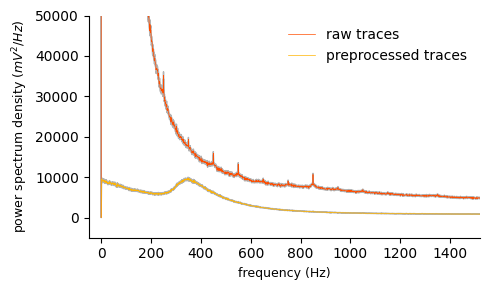

In [15]:
# plot power
assert all(reyes_fs[0] == reyes_pre_fs[0])
plot_power_spectrum_stats(reyes_psds, reyes_pre_psds, reyes_fs, color_raw=[1, 0.3, 0], color_prep=[1, 0.7, 0], ylim=[-5000, 5*1e4]);
plt.savefig("figures/2_realism/3_power/power_reyes.pdf"); #pdf
plt.savefig("figures/2_realism/3_power/power_reyes.svg"); #svg

#### Spectrum `Horvath`

In [4]:
# takes 26 min
# load
horvath_recording = se.NwbRecordingExtractor(DATA_PATH_horvath)
print(horvath_recording)

# preprocess (sampling frequency is 20,000 Hz)
horvath_recording_pre = spre.bandpass_filter(horvath_recording, freq_min=300, freq_max=9999)
horvath_recording_pre = spre.common_reference(horvath_recording_pre, reference='global', operator='median')

# calculate raw data power density spectrum for each splits of a channel trace
horvath_psds, horvath_fs = get_power_spectrum_horvath(horvath_recording, channel_id=CHANNEL_ID_horvath)

# calculate preprocessed data power density spectrum for each splits of a channel trace
horvath_pre_psds, horvath_pre_fs = get_power_spectrum_horvath(horvath_recording_pre, channel_id=CHANNEL_ID_horvath)

# sanity check preprocessing worked
horvath_recording_pre.is_filtered()

NwbRecordingExtractor: 128 channels - 1 segments - 20.0kHz - 3688.668s
  file_path: /gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/horvath/Rat01/Insertion1/Depth2/Rat01_Insertion1_Depth2.nwb


True

/tmp/ipykernel_168524/1627334896.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


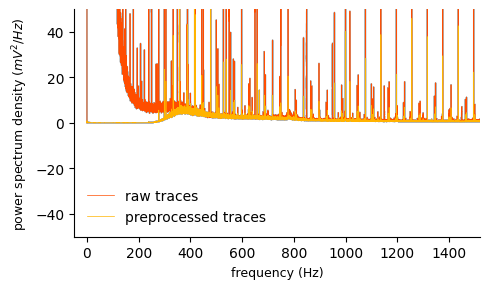

In [9]:
# plot power
assert all(horvath_fs[0] == horvath_pre_fs[0])
plot_power_spectrum_stats(horvath_psds, horvath_pre_psds, horvath_fs, color_raw=[1, 0.3, 0], color_prep=[1, 0.7, 0], ylim=[-50, 5*1e1]);
plt.savefig("figures/2_realism/3_power/power_horvath.pdf"); #pdf
plt.savefig("figures/2_realism/3_power/power_horvath.svg"); #svg

#### Spectrum `NPX-32CH-simulated_hex_O`

In [18]:
# takes 4 mins !

# load
our_recording_32 = si.load_extractor(RAW_RECORDING_PATH_32)

# preprocess (sampling frequency is 10 KHz so freq_max < 10,000 / 2)
our_recording_pre_32 = spre.bandpass_filter(our_recording_32, freq_min=300, freq_max=4999)
our_recording_pre_32 = spre.common_reference(our_recording_pre_32, reference='global', operator='median')

# calculate raw data power density spectrum for each splits of a channel trace
our_psds_raw_32, our_freqs_raw_32 = get_power_spectrum(our_recording_32, channel_id=CHANNEL_ID_32)

# calculate preprocessed data power density spectrum for each splits of a channel trace
our_psds_after_prep_32, our_fs_after_prep_32 = get_power_spectrum(our_recording_pre_32, channel_id=CHANNEL_ID_32)

# sanity check preprocessing worked
our_recording_pre_32.is_filtered()

True

/tmp/ipykernel_141169/1777047347.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


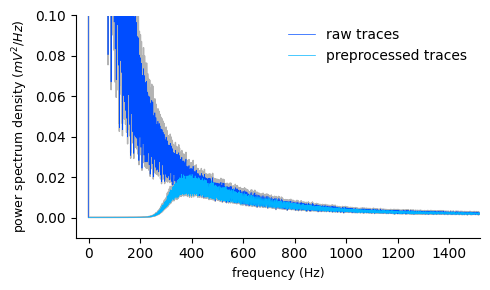

In [20]:
# plot npx-32
assert all(our_fs_after_prep_32[0] == our_freqs_raw_32[0])
plot_power_spectrum_stats(our_psds_raw_32, our_psds_after_prep_32, our_freqs_raw_32, color_raw=[0, 0.3, 1], color_prep=[0, 0.7, 1], ylim=[-0.01,0.1])
plt.savefig("figures/2_realism/3_power/power_npx32_sim_hex_0.pdf")
plt.savefig("figures/2_realism/3_power/power_npx32_sim_hex_0.svg")

#### Setup `NPX-384CH-simulated_hex_O1`

In [27]:
# takes 3 mins !

# load
our_recording_384 = si.load_extractor(RAW_RECORDING_PATH_384)

# preprocess (sampling frequency is 40 KHz so freq_max < 40,000 / 2)
our_recording_pre_384 = spre.bandpass_filter(our_recording_384, freq_min=300, freq_max=19999)
our_recording_pre_384 = spre.common_reference(our_recording_pre_384, reference='global', operator='median')

# calculate raw data power density spectrum for each splits of a channel trace
our_psds_raw_384, our_freqs_raw_384 = get_power_spectrum(our_recording_384, channel_id=CHANNEL_ID_384)

# calculate preprocessed data power density spectrum for each splits of a channel trace
our_psds_after_prep_384, our_fs_after_prep_384 = get_power_spectrum(our_recording_pre_384, channel_id=CHANNEL_ID_384)

/tmp/ipykernel_141169/1777047347.py:96: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


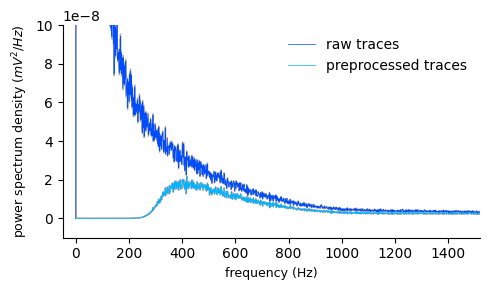

In [43]:
# plot npx-384
assert all(our_fs_after_prep_384[0] == our_freqs_raw_384[0])
plot_power_spectrum_stats(our_psds_raw_384, our_psds_after_prep_384, our_freqs_raw_384, color_raw=[0, 0.3, 1], color_prep=[0, 0.7, 1], ylim=[-0.1*10e-8,1*10e-8])
plt.savefig("figures/2_realism/3_power/power_npx384_sim_hex_01.pdf")
plt.savefig("figures/2_realism/3_power/power_npx384_sim_hex_01.svg")